# [Part 3] - Keypoint Detection

## Introduction: Keypoint Detection

In this final part of the project, we will be trying to predict the location of three joints on the subject's body to predict how curved the subject's back is. Since in the supine position, subject's back is already straight - not possible to detect the curve, I have used only **left** and **right** sleeping postures.

The original dataset did not have these labels. I generated them one-by-one using the software called *LabelMe*. There are three keypoints in the subject's body:
 - in shoulder
 - in mid body
 - in hip area

At the end of this part, we will draw a triangle using these three points with mid body point being in the middle and calculate the degree of this angle. Far the values from 180° worse the curve is for a sleeping position.

## Libraries

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import json
import os
from scipy import interpolate

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


## Hyperparameters and constants

In [24]:
IMG_WIDTH = 128
IMG_HEIGHT = 256
IMG_SIZE = 128
BATCH_SIZE = 6
EPOCHS = 1
NUM_KEYPOINTS = 3 * 2  # 3 pairs each having x and y coordinates
path_labels = '../data/keypoints/labels/all_labels.json'
IMG_DIR = '/Users/orkhanbayramli/Desktop/the-last-castle/HDA/project-sleep-posture-monitoring/data/keypoints/images'


The dataset takes the labels in a format in which all the images need to have:
- path to an image
- joints (x, y coordinates and visibility set to 1)

In order to generate a required json file for custom KeypointDataset please refer to this python script: [../src/data/generate_json_from_labels.py](../src/data/generate_json_from_labels.py)

In [26]:
# json dict containing all the labels
with open(path_labels) as json_file:
    json_all_labels = json.load(json_file)

## Helper functions

In [50]:
# Utility for reading an image and for getting its annotations.
def get_posture(name):
    data = json_all_labels[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    data["img_data"] = img_data
    return data

# Utility method for finding the angle between three points from 2D
def find_angle(keypoint):
    a, b, c = (point for point in (zip(keypoint[:, 1], keypoint[:, 0])))
    ang = math.degrees(math.atan2(
        c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return abs(ang) if abs(ang) < 180 else 360 - abs(ang)
    

Calculated angle:  160.22544158863258
Calculated angle:  167.54335593819576
Calculated angle:  158.87077463145096
Calculated angle:  176.04800065776155


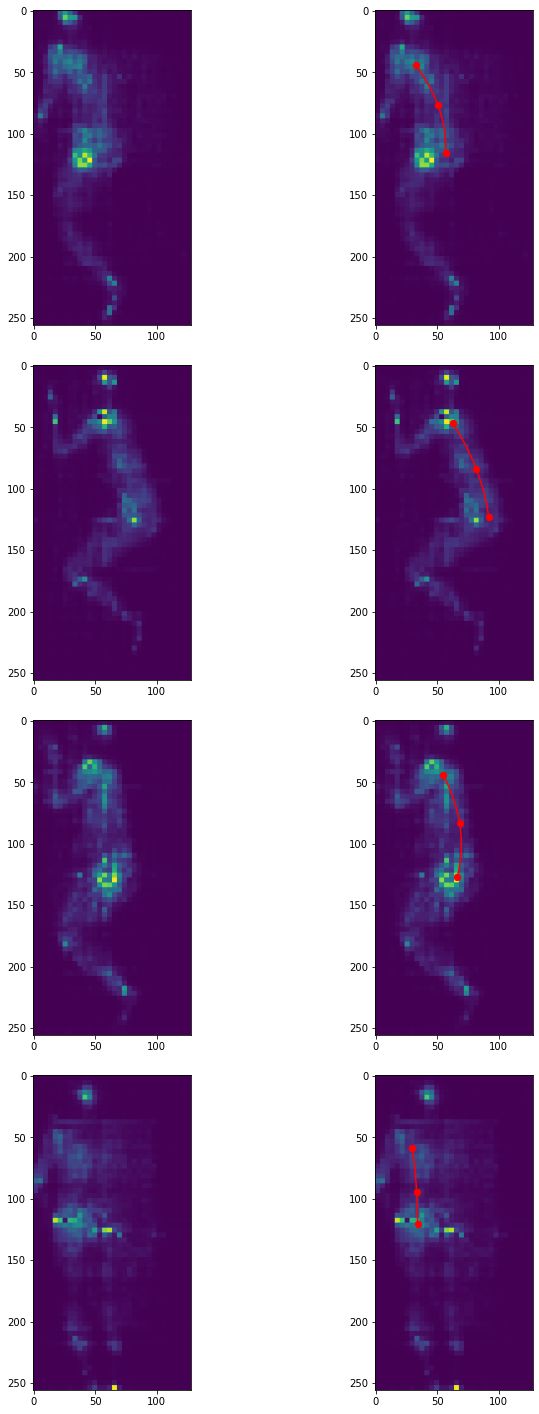

In [23]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb


def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(12, 20))

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        image = np.squeeze(image)
        ax_orig.imshow(image)
        ax_all.imshow(image)

        current_keypoint = np.array(current_keypoint)
        # Since the last entry is the visibility flag, we discard it.
        current_keypoint = current_keypoint[:, :2]
        for idx, (x, y) in enumerate(current_keypoint):
            ax_all.scatter([x], [y], c='red', marker="o", s=40)

        # x and y coordinates of keypoints
        """
        I am reversing the x and y coordinates because if you take a look at the
        keypoints on the images, we can see the x's values are non-increasing.
        Instead, y's values can be interpreted as x's and vice versa since
        it has increasing values.
        """
        x = current_keypoint[:, 1]
        y = current_keypoint[:, 0]

        _angle = find_angle(current_keypoint)
        print('Calculated angle: ', _angle)

        # To have smooth curve, change the last parameter value
        x2 = np.linspace(x[0], x[-1], 1000)
        # To get the curve between the keypoints I am using the Krogh interpolation.
        # Other methods are barycentric and pchip interpolations.
        y2 = interpolate.krogh_interpolate(x, y, x2)
        ax_all.plot(y2, x2, c='red')

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_all_labels.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_posture(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)


We can see that I have labelled some of the images wrongly since in the beginning I did not have any idea exacly which point on hip, shoulder, or body I have to choose. After couple of tries and training the model with bad annotations I got better idea of exactly where each point should be located in.

## Dataset

Dataset is a custom implementation of Sequence module from keras.utils. I have adjusted some parts of it to this dataset such that changing the number of channels, making sure that all the shapes are correct and all the keypoints exactly refer to their original coordinates.

In [36]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index *
                               self.batch_size: (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty(
            (self.batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype="int")
        batch_keypoints = np.zeros(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_posture(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(
                    Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            current_image = np.expand_dims(current_image, axis=-1)
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(
                image=current_image, keypoints=kps_obj)
            batch_images[i, ] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i, ] = np.array(kp_temp).reshape(1, 1, 3 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / 128

        return (batch_images, batch_keypoints)


I have kept this code just not to break or change something in KeypointsDataset that will cost me some time to debug and so on.

In [37]:
# Define augmentation transforms
train_aug = iaa.Sequential(
    [
        # iaa.Resize({ 'height': IMG_HEIGHT, 'width': IMG_WIDTH,}, interpolation="linear"),
        # iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        # iaa.Sometimes(0.3, iaa.Affine(rotate=20, scale=0.9)),
    ]
)

test_aug = iaa.Sequential([
    # iaa.Resize(IMG_SIZE, interpolation="linear")
])


In [38]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15):],
    samples[: int(len(samples) * 0.15)],
)


Now, let's generate the datasets from json dictionary and visualize some images to see if the labels match their original locations.

Total batches in training set: 36
Total batches in validation set: 6
Calculated angle:  147.83833602253154
Calculated angle:  180.1614971061484
Calculated angle:  167.5391826449896
Calculated angle:  167.621264935956


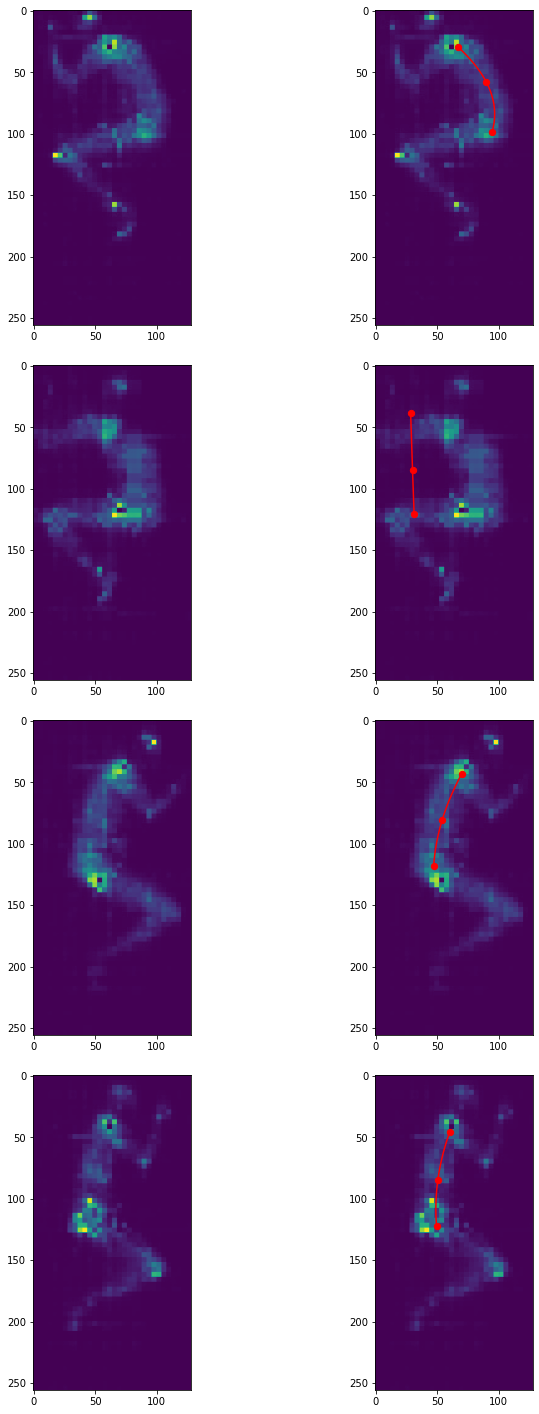

In [39]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, 3, 2) * IMG_WIDTH
visualize_keypoints(sample_images[:4], sample_keypoints)


## Model

The model is rather having a simple architecture containing some Convolutional layers and BatchNormalization layers. The most important part here is the last layers.

We have to decrease the number of kernels to `2 x NUM_KEYPOINTS = len((x, y)) * NUM_KEYPOINTS`. Meanwhile, the output shape of activations generated from the kernels should have the shape of *(1, 1)*. With the help of a utility function from keras, we can have a visualization of the layers with their sizes.

In [46]:
def get_model():
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))
    x = layers.Resizing(128, 128)(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters=32, kernel_size=3, strides=4, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="relu")(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="relu")(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=2, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 128, 1)]     0         
                                                                 
 resizing_10 (Resizing)      (None, 128, 128, 1)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_30 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        18464     
                                                 

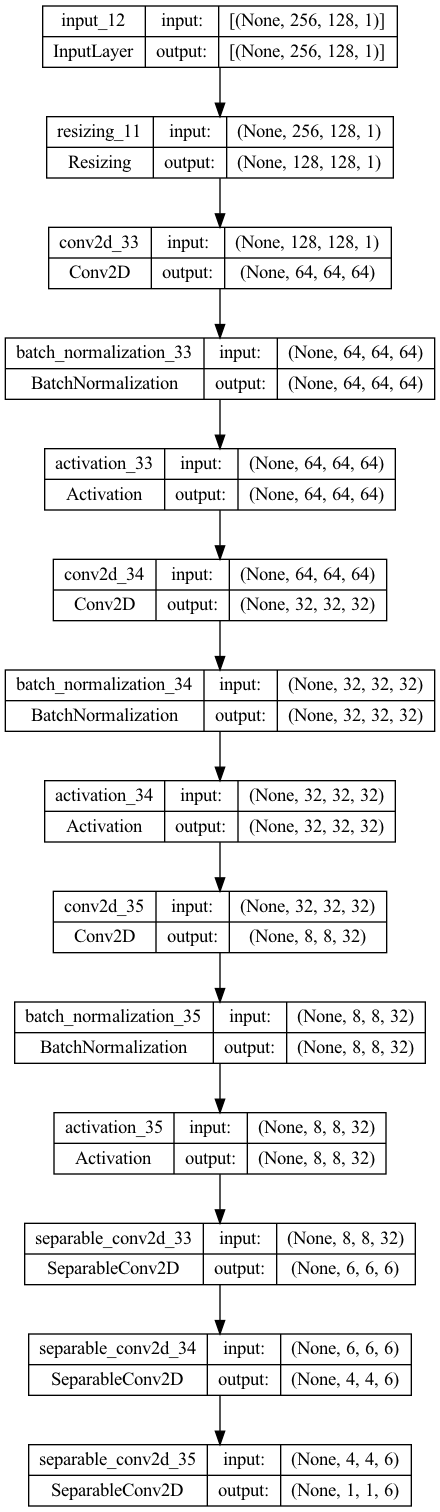

In [47]:
get_model().summary()
keras.utils.plot_model(get_model(), show_shapes=True, to_file='../figures/keypoint_detection_model.png')


As a loss function, I am using a Mean-Squared Error to measure how far off are the predicted coordinates from the actual ones.

**NOTE**: Loss function could be further extended to take into account also the angle that we calculate with the help of *get_angle()* function. I did not have time for that.

In [48]:
callbacks = [
    ModelCheckpoint("../models/keypoint_detection_model", save_best_only=True),
    TensorBoard(log_dir="../models/logs"),
    EarlyStopping(patience=5),
    ReduceLROnPlateau(patience=3)
]

model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-3))
model.fit(train_dataset, validation_data=validation_dataset,
          epochs=100, callbacks=callbacks)


Epoch 1/100
35/36 [============================>.] - ETA: 0s - loss: 0.0444

36/36 [==============================] - 5s 118ms/step - loss: 0.0438 - val_loss: 0.0343 - lr: 0.0010
Epoch 2/100
35/36 [============================>.] - ETA: 0s - loss: 0.0202

36/36 [==============================] - 4s 116ms/step - loss: 0.0199 - val_loss: 0.0277 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.0129

36/36 [==============================] - 4s 108ms/step - loss: 0.0129 - val_loss: 0.0171 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 0.0095

36/36 [==============================] - 4s 106ms/step - loss: 0.0095 - val_loss: 0.0128 - lr: 0.0010
Epoch 5/100
36/36 [==============================] - ETA: 0s - loss: 0.0077

36/36 [==============================] - 4s 118ms/step - loss: 0.0077 - val_loss: 0.0107 - lr: 0.0010
Epoch 6/100
36/36 [==============================] - ETA: 0s - loss: 0.0074

36/36 [==============================] - 4s 105ms/step - loss: 0.0074 - val_loss: 0.0085 - lr: 0.0010
Epoch 7/100
36/36 [==============================] - ETA: 0s - loss: 0.0068

36/36 [==============================] - 4s 104ms/step - loss: 0.0068 - val_loss: 0.0075 - lr: 0.0010
Epoch 8/100
36/36 [==============================] - ETA: 0s - loss: 0.0058

36/36 [==============================] - 4s 115ms/step - loss: 0.0058 - val_loss: 0.0069 - lr: 0.0010
Epoch 9/100
36/36 [==============================] - ETA: 0s - loss: 0.0049

36/36 [==============================] - 4s 105ms/step - loss: 0.0049 - val_loss: 0.0055 - lr: 0.0010
Epoch 10/100
36/36 [==============================] - 2s 60ms/step - loss: 0.0045 - val_loss: 0.0062 - lr: 0.0010
Epoch 11/100
36/36 [==============================] - ETA: 0s - loss: 0.0043

36/36 [==============================] - 4s 113ms/step - loss: 0.0043 - val_loss: 0.0042 - lr: 0.0010
Epoch 12/100
36/36 [==============================] - 2s 67ms/step - loss: 0.0038 - val_loss: 0.0045 - lr: 0.0010
Epoch 13/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0039 - val_loss: 0.0044 - lr: 0.0010
Epoch 14/100
36/36 [==============================] - ETA: 0s - loss: 0.0038

36/36 [==============================] - 4s 107ms/step - loss: 0.0038 - val_loss: 0.0041 - lr: 0.0010
Epoch 15/100
36/36 [==============================] - ETA: 0s - loss: 0.0033

36/36 [==============================] - 4s 108ms/step - loss: 0.0033 - val_loss: 0.0039 - lr: 1.0000e-04
Epoch 16/100
36/36 [==============================] - 2s 68ms/step - loss: 0.0032 - val_loss: 0.0041 - lr: 1.0000e-04
Epoch 17/100
36/36 [==============================] - 2s 68ms/step - loss: 0.0029 - val_loss: 0.0040 - lr: 1.0000e-04
Epoch 18/100
36/36 [==============================] - ETA: 0s - loss: 0.0030

36/36 [==============================] - 4s 122ms/step - loss: 0.0030 - val_loss: 0.0039 - lr: 1.0000e-04
Epoch 19/100
36/36 [==============================] - 2s 62ms/step - loss: 0.0030 - val_loss: 0.0039 - lr: 1.0000e-05
Epoch 20/100
36/36 [==============================] - 2s 63ms/step - loss: 0.0028 - val_loss: 0.0039 - lr: 1.0000e-05
Epoch 21/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0030 - val_loss: 0.0039 - lr: 1.0000e-05
Epoch 22/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0029 - val_loss: 0.0039 - lr: 1.0000e-06
Epoch 23/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0029 - val_loss: 0.0039 - lr: 1.0000e-06


## Results

1/1 [==============================] - 0s 204ms/step
Calculated angle:  169.17381269526115
Calculated angle:  172.37685648158023
Calculated angle:  167.5433637141469
Calculated angle:  174.2195902345619


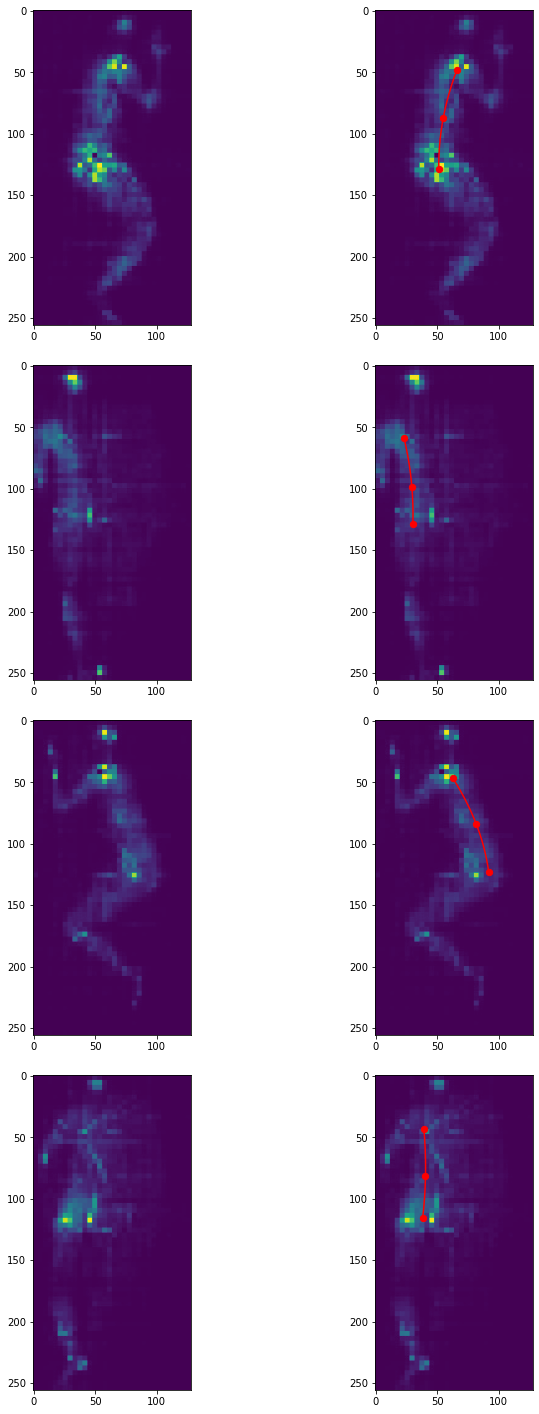

Calculated angle:  154.83278609909112
Calculated angle:  178.0493829213682
Calculated angle:  155.54709026651918
Calculated angle:  166.2584162240136


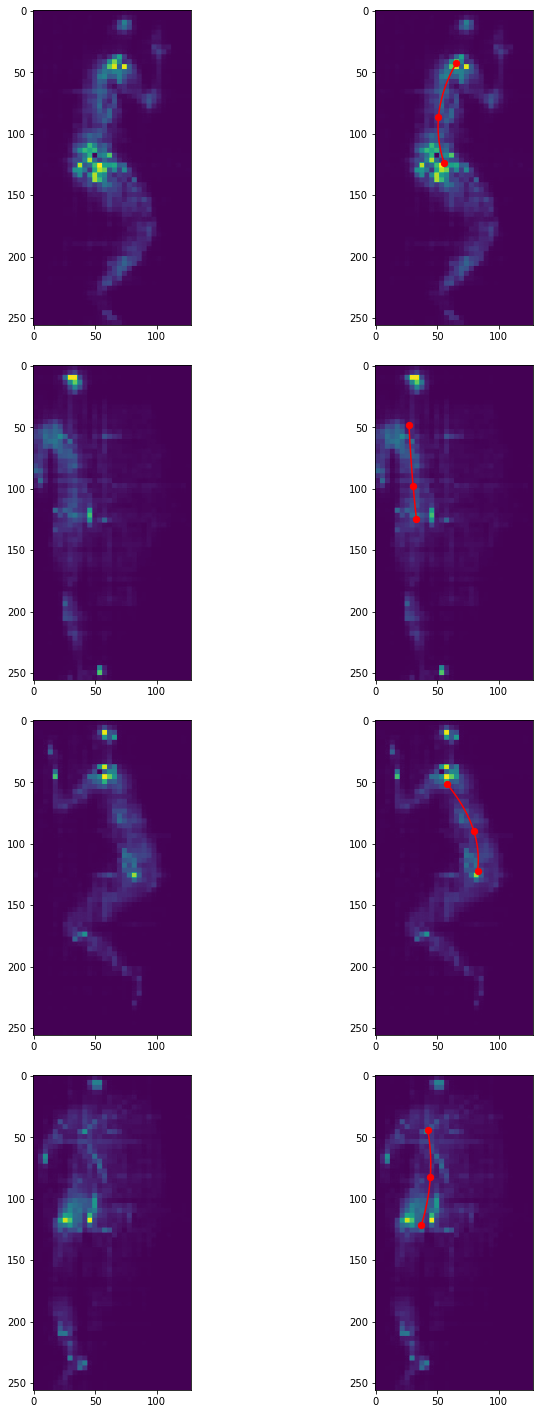

In [51]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 3, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 3, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)


From the results, we can conclude that the model works and it gives us the keypoints close to the original ones.

## Conclusion

We should also take into account that the original keypoints have **not** been annotated by any professional. They are just my annotations done in a small amount of time not paid very careful attention. I just wanted to see that if it is possible to do something like that.

One of the possible applications of keypoint detection would be to measure how curved one sleeps and assist or simply monitor the sleep quality taking into account that the small differences between original and predicted values are OK and *can be tolerated*. It could be more useful if we would be interested in relatively different values of an angle e.g. `angle < 155°` . Keypoints could also be used in other parts of the body. 

This is the end of the project. Thanks for visiting my page!